In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from transformers import AutoTokenizer

import lmppl
import json
import torch
import gc
from tqdm import tqdm


In [2]:
paraclite = pd.read_csv("../data/paraclite.csv")

In [3]:
paraclite.query('src_lang=="nl"')['nl'].values[100]

'Ip geen bezwaar tegen sporten zoals voorgenomen bij de revalidatie.'

In [4]:
nll_dict_256 = {
    'cardioberta_base_256': pd.read_csv("../output/cardioberta_nl/cardioberta_base/20251107-184317/nll.csv"),
    'cardioberta_clinical_256': pd.read_csv("../output/cardioberta_nl/cardioberta_clinical/20251107-195036/nll.csv"),
    'cardiomedroberta_256': pd.read_csv("../output/cardioberta_nl/cardiomedroberta/nov7_2025/20251107-174616/nll.csv"),
    'medroberta_256': pd.read_csv("../output/cardioberta_nl/medroberta/20251107/nll.csv"),
    'robbert2023_base_256': pd.read_csv("../output/cardioberta_nl/robbert2023-base/20251107/nll.csv"),
}
nll_dict_512 = {
    'cardioberta_base_512': pd.read_csv("../output/cardioberta_nl/cardioberta_base/nov07_2025/nll.csv"),
    'cardioberta_clinical_512': pd.read_csv("../output/cardioberta_nl/cardioberta_clinical/20251108-224048/nll.csv"),
    'cardiodeberta_clinical_512': pd.read_csv("../output/cardioberta_nl/cardiodeberta_clinical/20251110-093646/nll.csv"),
    'cardiomedroberta_512': pd.read_csv("../output/cardioberta_nl/cardiomedroberta/20251108-205724/nll.csv"),
    'medroberta_512': pd.read_csv("../output/cardioberta_nl/medroberta/20250224/nll.csv"),
    'robbert2023_base_512': pd.read_csv("../output/cardioberta_nl/robbert2023-base/nll.csv"),
}

(np.float64(0.036558352), np.float64(35.768917))

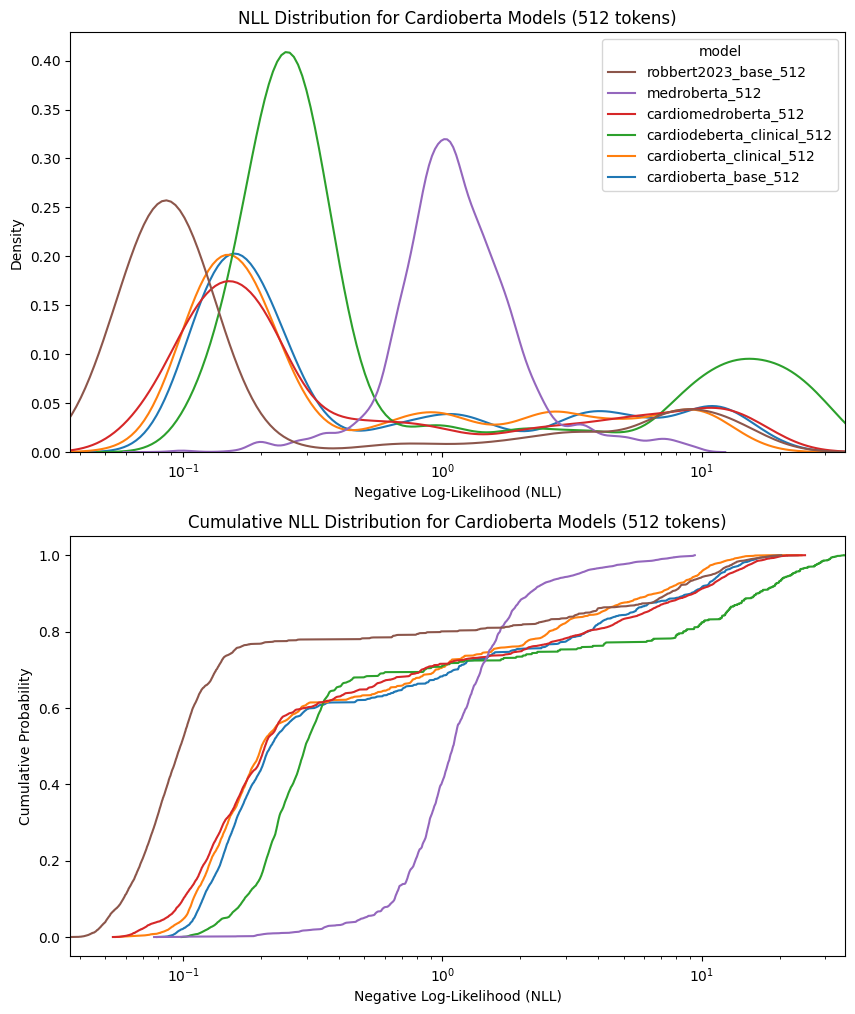

In [5]:
merged_df = pd.DataFrame()

fig, ax = plt.subplots(figsize=(10, 12), nrows=2, ncols=1)

model_names = list(nll_dict_512.keys())
palette = sns.color_palette("tab10", n_colors=len(model_names))
model_colors = dict(zip(model_names, palette))

for model_name, nll_df in nll_dict_512.items():
    nll_df['model'] = model_name
    merged_df = pd.concat([nll_df,merged_df], axis=0, ignore_index=True)

nll_min = merged_df['NLL'].min()
nll_max = merged_df['NLL'].max()

sns.kdeplot(data=merged_df, x='NLL', hue='model', ax=ax[0], log_scale=True, palette=model_colors)
ax[0].set_title('NLL Distribution for Cardioberta Models (512 tokens)')
ax[0].set_xlabel('Negative Log-Likelihood (NLL)')
ax[0].set_xlim(nll_min, nll_max)  # Set x-axis limits

for model_name, nll_df in nll_dict_512.items():
    sorted_nll = np.sort(nll_df['NLL'])
    cumulative = np.arange(1, len(sorted_nll) + 1) / len(sorted_nll)
    ax[1].plot(sorted_nll, cumulative, label=model_name, color=model_colors[model_name])
ax[1].set_title('Cumulative NLL Distribution for Cardioberta Models (512 tokens)')
ax[1].set_xscale('log')
ax[1].set_xlabel('Negative Log-Likelihood (NLL)')
ax[1].set_ylabel('Cumulative Probability')
ax[1].set_xlim(nll_min, nll_max)  # Set x-axis limits


In [6]:
paraclite = paraclite.query('src_lang=="nl"')
paraclite = paraclite.sort_values(['doc_name', 'seg_id'])

In [7]:
paraclite_agg = paraclite.groupby("doc_name")\
                    .apply(lambda x: x['nl'].str.cat(sep="\n"), include_groups=False)\
                    .reset_index()
paraclite_agg.columns = ['doc_name', 'text']

In [8]:
paraclite_agg.text.values[2]

'Datum: 06-12-2019\nBetreft: R.D. van Dijk, geb. \n02-03-1954, gesl. vrouw. \nGeachte collega,      \nBovengenoemde patiënt was op 06-12-2019 opgenomen op de Eerste Harthulp. \nSupervisor: B.E. van den Broek, cardioloog    \nVerwijzer\nzelf    \nReden van opname  \nThoracale pijnklachten    \nVoorgeschiedenis  Cardiaal  \n2007: Paroxysmaal atriumfibrilleren  \n2014: Evaluatie pijn op de borst en moeheid; MRI adenosine: g.a. voor ischemie of doorgemaakt infarct, goede LV en RV functie.  \n2014: 24-uurs bloeddrukregistratie 106/75mmHg, HR 65.  \n2015: Gedilateerd LA (47 ml/m2).  \n2015: paroxysmaal Afib, spontane conversie op EHH. \nMetoprolol verhoogd. \nCHADSVASC 4 (leeftijd, vrouw diabetes, hypertensie).  \n2017: pAF, waarvoor meerdere malen ECV. \nUiteindelijk sotalol vervangen door amiodaron met goed effect.   \n2017: Wegens aanhoudende thoracale klachten. \nMRI adenosine: Linkerventrikel met goede functie, geen aanwijzing voor ischemie of myocardiale fibrose.  \n2018: Myocardial in

In [6]:
def count_tokens(text, tokenizer_name='DTAI-KULeuven/robbert-2023-dutch-base'):
    tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)
    tokens = tokenizer.tokenize(text)
    return len(tokens)

In [ ]:
paraclite_agg['n_tokens_512_robbert'] = paraclite_agg['text'].apply(lambda x: count_tokens(x, 
                                        tokenizer_name='DTAI-KULeuven/robbert-2023-dutch-base'))

paraclite_agg['n_tokens_512_medroberta'] = paraclite_agg['text'].apply(lambda x: count_tokens(x, 
                                        tokenizer_name='CLTL/MedRoBERTa.nl'))

paraclite_agg['n_tokens_512_cardiodeberta'] = paraclite_agg['text'].apply(lambda x: count_tokens(x, 
                                        tokenizer_name='UMCU/CardioDeBERTa.nl_clinical'))

In [ ]:
paraclite_agg['rel_token_robbert2medroberta'] = paraclite_agg['n_tokens_512_robbert'] / paraclite_agg['n_tokens_512_medroberta']
paraclite_agg['rel_token_robbert2cardiodeberta'] = paraclite_agg['n_tokens_512_robbert'] / paraclite_agg['n_tokens_512_cardiodeberta']


In [ ]:
paraclite_agg.rel_token_robbert2medroberta.hist(bins=5)
paraclite_agg.rel_token_robbert2cardiodeberta.hist(bins=5)

paraclite_agg.rel_token_robbert2medroberta.mean(), paraclite_agg.rel_token_robbert2cardiodeberta.mean()

In [10]:
ppl_dict = {}
# read ppl from json files
ppl_dict = json.load(open('../output/ppl_paraclite.json'))

In [8]:
model_list = [
    'DTAI-KULeuven/robbert-2023-dutch-base',
    'DTAI-KULeuven/robbert-2023-dutch-large',
    'CLTL/MedRoBERTa.nl',
    'UMCU/CardioMedRoBERTa.nl',
    'UMCU/CardioDeBERTa.nl_clinical',
    'UMCU/CardioBERTa.nl_base',
    'UMCU/CardioBERTa.nl_clinical',
    'DT4H/CardioBERTa.it',
    'DT4H/CardioBERTa.cs',
    'DT4H/CardioBERTa.en',
    'DT4H/CardioBERTa.sv',
    'DT4H/CardioBERTa.ro',
    'DT4H/CardioBERTa.es',
    'FacebookAI/xlm-roberta-base',
    'google-bert/bert-large-cased',
    'google-bert/bert-base-cased'
]

In [ ]:
for _model_name in model_list:
    print(f"Calculating perplexity for {_model_name}...")
    scorer = lmppl.MaskedLM(_model_name, max_length=512)
    # clear CUDA memory
    # reset GPU memory
    torch.cuda.empty_cache()
    gc.collect()
    texts = list(paraclite_agg.text.values)
    ppl = scorer.get_perplexity(texts, batch_size=4)
    ppl_dict[_model_name] = ppl

In [ ]:
# # write to json
# import json
# with open('../output/ppl_paraclite.json', 'w') as f:
#     json.dump(ppl_dict, f)

In [11]:
ppl_df = pd.DataFrame()
for model_name, ppl_values in ppl_dict.items():
    ppl_df[model_name] = ppl_values 

In [ ]:
mod_run_dict = {
    'DTAI-KULeuven/robbert-2023-dutch-base': 'RobBERT 2023 Base',
    'DTAI-KULeuven/robbert-2023-dutch-large': 'RobBERT 2023 Large',
    'CLTL/MedRoBERTa.nl': 'MedRoBERTa.nl',
    'UMCU/CardioMedRoBERTa.nl': 'CardioMedRoBERTa.nl',
    'UMCU/CardioDeBERTa.nl_clinical': 'CardioDeBERTa.nl Clinical',
    'UMCU/CardioBERTa.nl_base': 'CardioBERTa.nl Base',
    'UMCU/CardioBERTa.nl_clinical': 'CardioBERTa.nl Clinical',
    'DT4H/CardioBERTa.it': 'CardioBERTa.it',
    'DT4H/CardioBERTa.cs': 'CardioBERTa.cs',
    'DT4H/CardioBERTa.en': 'CardioBERTa.en',
    'DT4H/CardioBERTa.sv': 'CardioBERTa.sv',
    'DT4H/CardioBERTa.ro': 'CardioBERTa.ro',
    'DT4H/CardioBERTa.es': 'CardioBERTa.es',
    'FacebookAI/xlm-roberta-base': 'XLM-Roberta Base (multi)',
    'google-bert/bert-large-cased': 'BERT Large Cased (en)',
    'google-bert/bert-base-cased': 'BERT Base Cased (en)'
}

In [ ]:
ppl_df.rename(columns=mod_run_dict, inplace=True)

In [14]:
# I want to sort the columns by the median of the perplexity values
median_perplexities = ppl_df.median().sort_values()
ppl_df = ppl_df[median_perplexities.index]

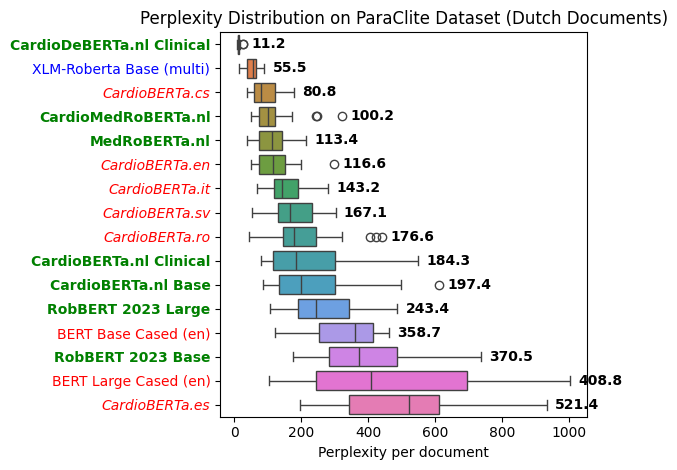

In [15]:
sns.boxplot(data=ppl_df, orient='h')
plt.title('Perplexity Distribution on ParaClite Dataset (Dutch Documents)')
plt.xlabel('Perplexity per document')

# Get current y-tick positions and labels
ax = plt.gca()
y_ticks = ax.get_yticks()
y_labels = [label.get_text() for label in ax.get_yticklabels()]

# Prepare new labels and font properties
new_labels = []
fontdicts = []
for text in y_labels:
    if '.nl' in text or 'RobBERT' in text:
        fontdicts.append({'weight': 'bold', 'color': 'green'})
    elif 'Cardio' in text:
        fontdicts.append({'style': 'italic', 'color': 'red'})
    elif 'multi' in text:
        fontdicts.append({'color': 'blue'})
    else:
        fontdicts.append({'color': 'red'})
    new_labels.append(text)

# Set ticks and labels with font properties
ax.set_yticks(y_ticks)
for i, (label, fontdict) in enumerate(zip(new_labels, fontdicts)):
    ax.get_yticklabels()[i].set_fontweight(fontdict.get('weight', 'normal'))
    ax.get_yticklabels()[i].set_fontstyle(fontdict.get('style', 'normal'))
    if 'color' in fontdict:
        ax.get_yticklabels()[i].set_color(fontdict['color'])
    ax.get_yticklabels()[i].set_text(label)
ax.set_yticklabels(new_labels)

# Annotate median and mean perplexities
for i, col in enumerate(ppl_df.columns):
    median = np.median(ppl_df[col].dropna())
    mean = np.mean(ppl_df[col].dropna())
    xpos = ppl_df[col].max()+25  # Place annotation just right of the max value
    ypos = y_ticks[i]
    ax.text(xpos, ypos, f"{median:.1f}", 
            va='center', ha='left',
            fontdict={'weight': 'bold', 'color': 'black'},
            fontsize=10, color='black')


plt.tight_layout()
plt.savefig('../output/ppl_paraclite_distribution.png', dpi=300)


# Perplexity versus MLM proba

In [16]:
from pppl import ppl_alt

In [46]:
probs = [0.05, 0.10, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5]
model_names = mod_run_dict.keys()
ppl_res = []

for _model_name in model_names:
    for _prob in tqdm(probs):
        summary, token_results = ppl_alt.process_text(text=paraclite_agg.text.values[0], 
                            model_name=_model_name,
                            model_type='encoder',
                            mask_probability=_prob,
                            min_samples=5)
        
        token_results = [t for t in token_results if np.isinf(t[1]) == np.False_]
        
        ppl_res_dict = {
            'model_name': _model_name,
            'mask_probability': _prob,
            'summary': summary,
            'token_results': token_results
        }
        ppl_res.append(ppl_res_dict)
    

  0%|          | 0/8 [00:00<?, ?it/s]Some weights of the model checkpoint at FacebookAI/xlm-roberta-base were not used when initializing XLMRobertaForMaskedLM: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
  0%|          | 0/8 [00:00<?, ?it/s]Some weights of the model checkpoint at google-bert/bert-large-cased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are in

In [48]:
res_final_df = pd.DataFrame([{
  'model_name': d['model_name'],
  'mask_probability': d['mask_probability'], 
  'median_ppl': np.median([t[1] for t in d['token_results']]),
  'mean_ppl': np.mean([t[1] for t in d['token_results']])} for d in ppl_res])

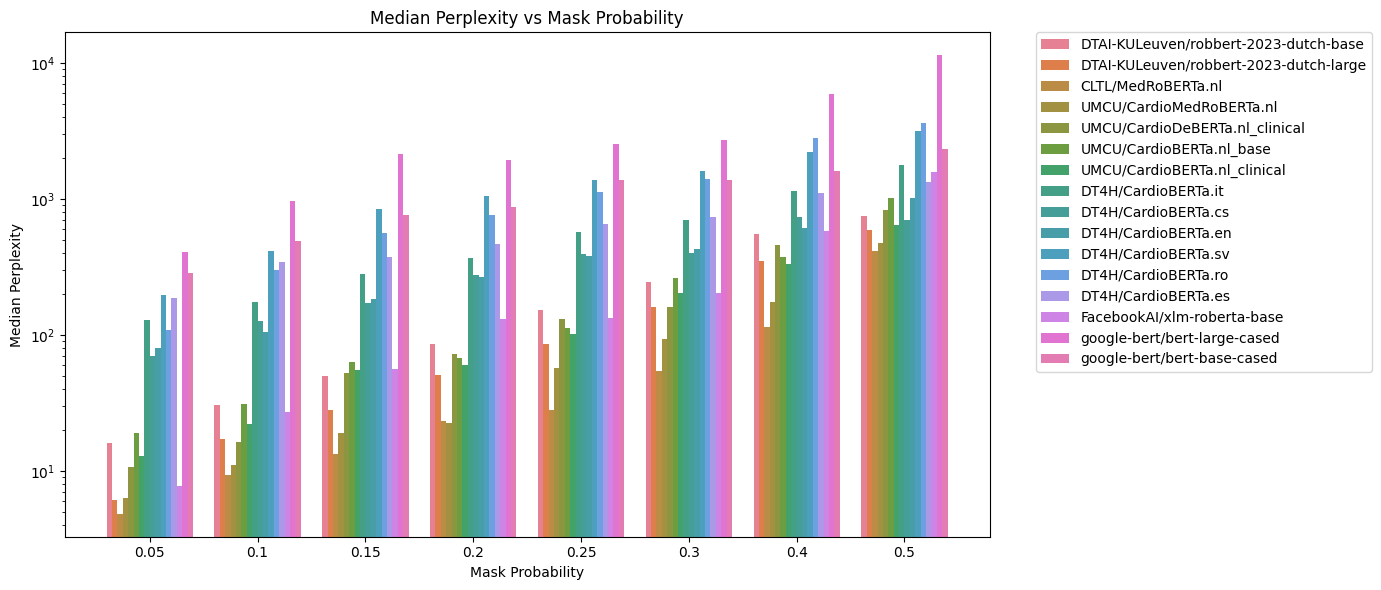

In [ ]:
ax = plt.figure(figsize=(14,6))
sns.barplot(data=res_final_df, 
            x='mask_probability', 
            y='median_ppl', 
            hue='model_name')
plt.title('Median Perplexity vs Mask Probability')
plt.xlabel('Mask Probability')
plt.ylabel('Median Perplexity')
plt.semilogy()

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.tight_layout()